In [ ]:
import nltk
import pickle
import torch
import tiktoken
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from umap import UMAP
from urllib.parse import urlparse
from nltk.corpus import brown
from sentence_transformers import SentenceTransformer, util
from langchain.text_splitter import TokenTextSplitter

In [ ]:
nltk.download('brown')

In [3]:
embeddings_location = 'page-embeddings-selected.pkl'

print("Loading pre-computed embeddings from disc: " + embeddings_location)
with open(embeddings_location, "rb") as reader:
    cache_data = pickle.load(reader)
    sections = cache_data['sections']
    corpus_embeddings = cache_data['embeddings']

print('Corpus embeddings loaded.')
print('Corpus embedding size:', corpus_embeddings.shape)

Loading pre-computed embeddings from disc: page-embeddings-selected.pkl
Corpus embeddings loaded.
Corpus embedding size: (8469, 384)


In [4]:
enc = tiktoken.encoding_for_model("text-davinci-003")
text_splitter = TokenTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)

words = ' '.join(brown.words())
paras = text_splitter.create_documents([words])

In [5]:
if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook.")

bi_encoder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
bi_encoder.max_seq_length = 256

def getContent(para):
    return para.page_content

passages = []
passages.extend(map(getContent, paras))

print('Passages:', len(passages))

quality_embeddings = bi_encoder.encode(passages, convert_to_tensor=True)

print('Quality embeddings created.')
print('Quality embedding size:', quality_embeddings.shape)

Passages: 5116
Quality embeddings created.
Quality embedding size: torch.Size([5116, 384])


In [6]:
cos_sims = util.cos_sim(corpus_embeddings, quality_embeddings.cpu())
print('Number of similarities computed:', len(cos_sims))

Number of similarities computed: 8469


In [7]:
umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
embeddings_umap = umap_fit.fit_transform(corpus_embeddings)

In [13]:
df = pd.DataFrame.from_records(pd.json_normalize(sections, sep='_'))
df['score'] = list(map(lambda x: x.mean(), cos_sims.numpy()))
df['content'].apply(lambda x: x.replace('\n', ' ').strip())
df['domain'] = df['page_url'].apply(lambda x: urlparse(x).netloc)
df['long'] = df['tokens'].apply(lambda x: x > 230)
df['x'] = embeddings_umap[:, 0]
df['y'] = embeddings_umap[:, 1]
df['z'] = embeddings_umap[:, 2]

threshold = np.percentile(df['score'], 10)
df['partition'] = df['score'].apply(lambda x: x > threshold)

Threshold: 0.09732469916343689


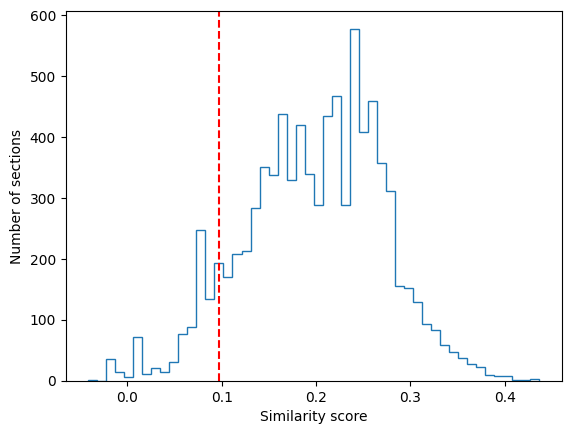

In [14]:
plt_range = [df['score'].min(), df['score'].max()]

counts, bins = np.histogram(df['score'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)
plt.axvline(threshold, color='r', linestyle='--')
plt.xlabel('Similarity score')
plt.ylabel('Number of sections')

print('Threshold:', threshold)

Text(0, 0.5, 'Number of Sections')

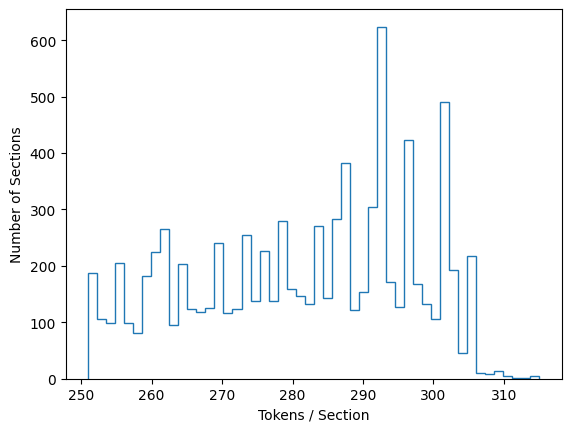

In [15]:
plt_range_token = [df['tokens'].min(), df['tokens'].max()]

counts, bins = np.histogram(df['tokens'], range=plt_range_token, bins=50)
diagram = plt.stairs(counts, bins)
plt.xlabel('Tokens / Section')
plt.ylabel('Number of Sections')

In [12]:
df['partition'] = df['score'].apply(lambda x: x > threshold)
df['long'] = df['tokens'].apply(lambda x: x > 230)

In [ ]:
fig_3d_tokens = px.scatter_3d(
    df, x='x', y='y', z='z',
    color=df['tokens'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_tokens.update_traces(marker_size=5)
fig_3d_tokens.show()

fig_3d_score = px.scatter_3d(
    df, x='x', y='y', z='z',
    color=df['score'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_score.update_traces(marker_size=5)
fig_3d_score.show()

fig_3d_partition = px.scatter_3d(
    df, x='x', y='y', z='z',
    color=df['partition'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_partition.update_traces(marker_size=5)
fig_3d_partition.show()

fig_3d_long = px.scatter_3d(
    df, x='x', y='y', z='z',
    color=df['long'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_long.update_traces(marker_size=5)
fig_3d_long.show()

df.sample(10)

In [18]:
scoresFrame = df['score'].to_numpy()
sorted_ids = scoresFrame.argsort()
scores = scoresFrame[sorted_ids]

print('Threshold:', threshold)

numpy_sections = np.array(sections)

good_ids = sorted_ids[scores >= threshold]
bad_ids = sorted_ids[scores < threshold]

Threshold: 0.09732469916343689


,content,tokens,page_url,page_title,page_summary,score,domain,long,x,y,z,partition
5760,It’s best to avoid shortening noun and verb co...,258,https://orbit.kiwi/kiwi-use/content/technical-...,Technical content | Orbit,"In general, follow the guidelines in the gramm...",0.228054,orbit.kiwi,True,9.930954,2.960732,8.826125,True
3263,"In mainframe, computing was hidden away, batch...",292,https://www.designbetter.co/conversations/john...,John Allsopp: the consequences of the web - De...,Featuring John Allsopp Author & conference org...,0.322226,www.designbetter.co,True,7.055266,1.810037,9.656989,True
3090,Strictly Necessary Cookies\nAlways ActiveThese...,301,https://design.gitlab.com/components/badge/code,Badge | Pajamas Design System,Badge A badge highlights system generated meta...,0.256520,design.gitlab.com,True,8.396305,-12.572338,11.715217,True
2810,Primary optionsNameTypeDescriptiontitleTextstr...,263,https://design-system.service.gov.uk/component...,Error summary – GOV.UK Design System,Error summary Use this component at the top of...,0.133770,design-system.service.gov.uk,True,-0.264347,3.237225,11.719884,True
1838,\nI’m less competent at JS than HTML and CSS\n...,288,https://bradfrost.com/blog/post/my-struggle-to...,My struggle to learn React | Brad Frost,My struggle to learn React I’m going to be hon...,0.217875,bradfrost.com,True,6.425530,3.393805,8.337297,True
3951,Usability guidance\n\nDeprecated USWDS 2.10.2 ...,260,https://designsystem.digital.gov/templates/for...,Address form | U.S. Web Design System (USWDS),Templates Address form Enter a standard U.S. m...,0.155634,designsystem.digital.gov,True,10.889936,3.113319,8.863346,True
3604,What should you measure and how do you do it?\...,274,https://designstrategy.guide/design-strategy/h...,How to demonstrate design’s value and measure ...,"Great design leads to great products, and grea...",0.173341,designstrategy.guide,True,7.743427,4.196016,8.772149,True
6843,"\nStructured, Arbitrary Code: Query languages ...",287,https://react.dev/blog/2015/05/01/graphql-intr...,GraphQL Introduction – React Blog,GraphQL Introduction Nick Schrock This blog si...,0.215135,react.dev,True,8.163272,2.762233,7.350890,True
8157,Veda Rosier:\nYeah. I think very much so. And ...,299,https://www.knapsack.cloud/blog/dsp-43-adobe,"Building an accessible, inclusive design syste...","Matt, Veda, and Chris discuss how Matt and Ved...",0.316154,www.knapsack.cloud,True,5.041658,5.348835,8.152236,True
1275,An error message alerts people of a problem th...,303,https://atlassian.design/components/portal,Portal - Examples - Components - Atlassian Des...,Portals render parts of a React component tree...,0.271442,atlassian.design,True,6.955917,-3.032642,-11.372223,True


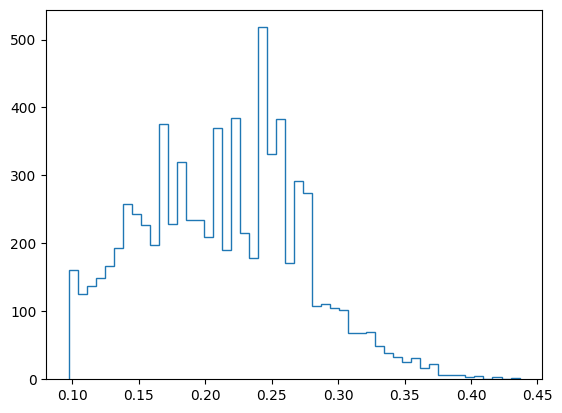

In [19]:
df_good = df.iloc[good_ids]
plt_range = [df_good['score'].min(), df_good['score'].max()]

counts, bins = np.histogram(df_good['score'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

df_good.sample(10)

In [ ]:
fig_3d_tokens = px.scatter_3d(
    df_good, x='x', y='y', z='z',
    color=df_good['tokens'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_tokens.update_traces(marker_size=5)
fig_3d_tokens.show()

fig_3d_score = px.scatter_3d(
    df_good, x='x', y='y', z='z',
    color=df_good['score'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_score.update_traces(marker_size=5)
fig_3d_score.show()

fig_3d_long = px.scatter_3d(
    df_good, x='x', y='y', z='z',
    color=df_good['long'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_long.update_traces(marker_size=5)
fig_3d_long.show()

df_good.sample(10)

,content,tokens,page_url,page_title,page_summary,score,domain,long,x,y,z,partition
1984,"I wrote a book called Atomic Design, which cov...",262,https://bradfrost.com/blog/post/atomic-design-...,Atomic Design in one GIF | Brad Frost,My name is Brad Frost Work Book Blog Contact A...,0.079029,bradfrost.com,True,7.365597,-5.136398,23.620979,False
5724,### Use specific action textIn addition to a l...,272,https://orbit.kiwi/components/input/inputfile/,InputFile component | Orbit,When not to use To collect small pieces of in...,0.095278,orbit.kiwi,True,10.696031,3.172892,8.536261,False
5304,Security Patch\nThe Next.js team works with se...,287,https://nextjs.org/blog/next-11-1,Blog - Next.js 11.1 | Next.js,We're improving build performance across the e...,0.056257,nextjs.org,True,7.803769,2.250639,6.545985,False
4395,Schema\nJson file that holds the shape of data...,275,https://help.knapsack.cloud/article/6-glossary,Glossary - Knowledge Base | Knapsack,Glossary Here's a list of terms used in Knapsa...,0.091356,help.knapsack.cloud,True,9.392017,1.367208,6.393127,False
4873,CSS\nA lot of motion can be done using CSS alo...,286,https://www.lightningdesignsystem.com/kinetics...,Implementing Kinetics - Lightning Design System,Kinetics System Implementing Kinetics Kinetics...,0.082955,www.lightningdesignsystem.com,True,10.300439,3.767978,7.649770,False
1983,"I wrote a book called Atomic Design, which cov...",262,https://bradfrost.com/blog/post/death-to-bulls...,Death to Bullshit | Brad Frost,Death to Bullshit I’m pleased to introduce Dea...,0.079029,bradfrost.com,True,7.696752,-5.076772,23.717030,False
4202,"Getting the Fonts, Whether by Download, Link, ...",262,https://eightshapes.com/articles/typography-in...,Eightshapes > @components > Typopgraphy in Des...,Everyday digital interfaces include a rich var...,0.092311,eightshapes.com,True,8.628425,2.698853,8.918766,False
5440,Examples\n* Custom Server\n* SSR Caching\nBy d...,269,https://nextjs.org/docs/advanced-features/cust...,Advanced Features: Custom Server | Next.js,"If you have an existing backend, you can still...",0.064144,nextjs.org,True,8.270798,1.842010,5.807364,False
7930,How do I use media queries defined in tokens? ...,298,https://www.duetds.com/faq/,FAQ | Duet Design System,Duet Design System is a collection of reusable...,0.033731,www.duetds.com,True,8.792740,1.539305,6.639108,False
5886,Product style guide - Paste: The Design System...,300,https://paste.twilio.design/foundations/conten...,Product style guide - Paste: The Design System...,"Product style guide Core principles, punctuati...",-0.008292,paste.twilio.design,True,2.225343,2.048616,19.791378,False


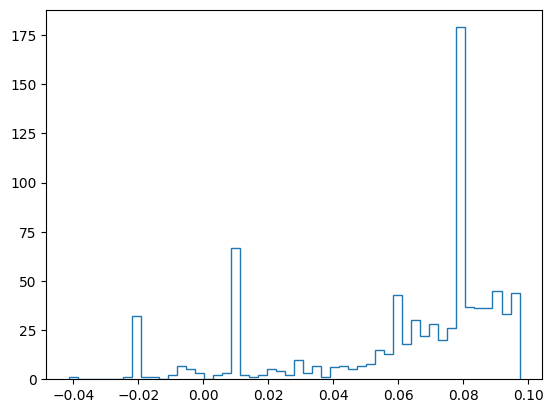

In [22]:
df_bad = df.iloc[bad_ids]
plt_range = [df_bad['score'].min(), df_bad['score'].max()]

counts, bins = np.histogram(df_bad['score'], range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)

df_bad.sample(10)

In [ ]:
fig_3d_tokens = px.scatter_3d(
    df_bad, x='x', y='y', z='z',
    color=df_bad['tokens'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_tokens.update_traces(marker_size=5)
fig_3d_tokens.show()

fig_3d_score = px.scatter_3d(
    df_bad, x='x', y='y', z='z',
    color=df_bad['score'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_score.update_traces(marker_size=5)
fig_3d_score.show()

fig_3d_long = px.scatter_3d(
    df_bad, x='x', y='y', z='z',
    color=df_bad['long'], hover_data=['content'], color_continuous_scale=px.colors.sequential.Viridis,
    width=800, height=800
)
fig_3d_long.update_traces(marker_size=5)
fig_3d_long.show()

df_bad.sample(10)